## Imports

In [0]:
from keras.layers import Input, Embedding, dot, add,Flatten, concatenate,Dropout, Dense
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import Adam
# import textdistance
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from operator import itemgetter


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

# settings
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/gdrive')

# Bioresponse = pd.read_csv('/content/gdrive/My Drive/Final Project/Code/DataSets/Bioresponse.csv')
# # OVA_Colon = pd.read_csv('/content/gdrive/My Drive/Final Project/Code/DataSets/OVA_Colon.csv')
# gene_expression_cancer_data = pd.read_csv('/content/gdrive/My Drive/Final Project/Code/DataSets/gene expression cancer RNA-Seq/data.csv')
# gene_expression_cancer_labels = pd.read_csv('/content/gdrive/My Drive/Final Project/Code/DataSets/gene expression cancer RNA-Seq/labels.csv')




Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Extracting Dataset into pandas DataFrame

1.   List item
2.   List item



In [1]:
import os
def get_dataset(data_file, label_file=None, csv=True, remote=True):
    data = None
    label = None
    file_extention = 'csv' if csv else 'dat'
    if remote:
        data = pd.read_csv(f'/content/gdrive/My Drive/Final Project/Code/DataSets/{data_file}.{file_extention}')
        if label_file != None:
            label = pd.read_csv(f'/content/gdrive/My Drive/Final Project/Code/DataSets/{label_file}.{file_extention}')
    else:
        path = os.path.abspath(os.path.dirname(__file__))
        data = pd.read_csv(os.join(path, f'{data_file}.{file_extention}'))
        if label_file != None:
            label = pd.read_csv(os.join(path, f'{label_file}.{file_extention}'))

    return data, label


Usage example

In [0]:
# bioresponse, redundant = get_dataset('Bioresponse')
# print(bioresponse.shape)

# cancer , red = get_dataset('gene expression cancer RNA-Seq/data', label_file='gene expression cancer RNA-Seq/labels')
# print(cancer.shape)
# print(red.shape)

(3751, 1777)

## Data cleaning

In [0]:
# normalization
def drop_columns_with_one_value(df):
 df_copy = df.copy()
 for column in df.columns:
  if (len(df[column].unique()) == 1):
   df_copy.drop(column, inplace=True,axis=1)
 return df_copy

def normalize(df, method):
    if method == 'min-max':
        return (df-df.min())/(df.max()-df.min())
    elif method == 'norm':
        return (df - df.mean())/df.std()
    else:
        raise NotImplementedError('Other normalization not implemented yet')
   

Data splitting


In [0]:
import math
def split_data(df_data, df_label, data_name):
    if data_name == 'Bioresponse':
        Bioresponse = drop_columns_with_one_value(df_data)
        Bioresponse = normalize(Bioresponse, 'min-max')
        Bioresponse_taret_0 = Bioresponse.loc[Bioresponse['target']==0]
        Bioresponse_taret_1 = Bioresponse.loc[Bioresponse['target']==1]
        Bioresponse_taret_0.shape,Bioresponse_taret_1.shape

        X_train_taret_0 = Bioresponse_taret_0.iloc[0:math.trunc(Bioresponse_taret_0.shape[0]*0.6)]
        X_train_taret_1 = Bioresponse_taret_1.iloc[0:math.trunc(Bioresponse_taret_1.shape[0]*0.6)]
        X_train = pd.concat([X_train_taret_0, X_train_taret_1], ignore_index=False, sort=False)
        X_train.shape

        X_validation_taret_0 = Bioresponse_taret_0.iloc[math.trunc(Bioresponse_taret_0.shape[0]*0.6) :math.trunc(Bioresponse_taret_0.shape[0]*0.8)]
        X_validation_taret_1 = Bioresponse_taret_1.iloc[math.trunc(Bioresponse_taret_1.shape[0]*0.6) :math.trunc(Bioresponse_taret_1.shape[0]*0.8)]
        X_validation = pd.concat([X_validation_taret_0, X_validation_taret_1], ignore_index=False, sort=False)
        X_validation.shape

        X_test_taret_0 = Bioresponse_taret_0.iloc[math.trunc(Bioresponse_taret_0.shape[0]*0.8):]
        X_test_taret_1 = Bioresponse_taret_1.iloc[math.trunc(Bioresponse_taret_1.shape[0]*0.8):]
        X_test = pd.concat([X_test_taret_0, X_test_taret_1], ignore_index=False, sort=False)

        y_train = X_train['target']
        y_validation = X_validation['target']
        y_test = X_test['target']

        X_train=X_train.drop('target', axis=1)
        X_validation=X_validation.drop('target',axis=1)
        X_test=X_test.drop('target',axis=1)

        X_train_transpose = X_train.T
        X_validation_transpose = X_validation.T
        X_test_transpose = X_test.T

        return {
            'train' : {
                'original' : X_train,
                'transpose' : X_train.T,
                'labels' : y_train
            },
            'validation' : {
                'original' : X_validation,
                'transpose' : X_validation.T,
                'labels' : y_validation
            },
            'test' : {
                'original' : X_test,
                'transpose' : X_test.T,
                'labels' : y_test
            }
        }

    elif data_name == 'gene_expression_cancer_data':
        gene_expression_cancer_data = df_data
        gene_expression_cancer_labels = df_label
        gene_expression_cancer_data.drop('Unnamed: 0', inplace=True,axis=1)
        gene_expression_cancer_data = drop_columns_with_one_value(gene_expression_cancer_data)
        gene_expression_cancer_data = normalize(gene_expression_cancer_data, 'min-max')
        gene_expression_cancer_data['target'] = gene_expression_cancer_labels['Class']
        classDictionary = {
        "PRAD": 0,
        "LUAD": 1,
        "BRCA": 2,
        "KIRC": 3,
        "COAD": 4
        }
        gene_expression_cancer_data = gene_expression_cancer_data.applymap(lambda s: classDictionary.get(s) if s in classDictionary else s)

        gene_expression_cancer_data_0 = gene_expression_cancer_data.loc[gene_expression_cancer_data['target']==0]
        gene_expression_cancer_data_1 = gene_expression_cancer_data.loc[gene_expression_cancer_data['target']==1]
        gene_expression_cancer_data_2 = gene_expression_cancer_data.loc[gene_expression_cancer_data['target']==2]
        gene_expression_cancer_data_3 = gene_expression_cancer_data.loc[gene_expression_cancer_data['target']==3]
        gene_expression_cancer_data_4 = gene_expression_cancer_data.loc[gene_expression_cancer_data['target']==4]


        X_train_target_0 = gene_expression_cancer_data_0.iloc[0:math.trunc(gene_expression_cancer_data_0.shape[0]*0.6)]
        X_train_target_1 = gene_expression_cancer_data_1.iloc[0:math.trunc(gene_expression_cancer_data_1.shape[0]*0.6)]
        X_train_target_2 = gene_expression_cancer_data_2.iloc[0:math.trunc(gene_expression_cancer_data_2.shape[0]*0.6)]
        X_train_target_3 = gene_expression_cancer_data_3.iloc[0:math.trunc(gene_expression_cancer_data_3.shape[0]*0.6)]
        X_train_target_4 = gene_expression_cancer_data_4.iloc[0:math.trunc(gene_expression_cancer_data_4.shape[0]*0.6)]
        X_train = pd.concat([X_train_target_0, X_train_target_1,X_train_target_2,X_train_target_3,X_train_target_4], ignore_index=False, sort=False)


        X_validation_target_0 = gene_expression_cancer_data_0.iloc[math.trunc(gene_expression_cancer_data_0.shape[0]*0.6) :math.trunc(gene_expression_cancer_data_0.shape[0]*0.8)]
        X_validation_target_1 = gene_expression_cancer_data_1.iloc[math.trunc(gene_expression_cancer_data_1.shape[0]*0.6) :math.trunc(gene_expression_cancer_data_1.shape[0]*0.8)]
        X_validation_target_2 = gene_expression_cancer_data_2.iloc[math.trunc(gene_expression_cancer_data_2.shape[0]*0.6) :math.trunc(gene_expression_cancer_data_2.shape[0]*0.8)]
        X_validation_target_3 = gene_expression_cancer_data_3.iloc[math.trunc(gene_expression_cancer_data_3.shape[0]*0.6) :math.trunc(gene_expression_cancer_data_3.shape[0]*0.8)]
        X_validation_target_4 = gene_expression_cancer_data_4.iloc[math.trunc(gene_expression_cancer_data_4.shape[0]*0.6) :math.trunc(gene_expression_cancer_data_4.shape[0]*0.8)]
        X_validation = pd.concat([X_validation_target_0, X_validation_target_1,X_validation_target_2,X_validation_target_3,X_validation_target_4], ignore_index=False, sort=False)


        X_test_target_0 = gene_expression_cancer_data_0.iloc[math.trunc(gene_expression_cancer_data_0.shape[0]*0.8):]
        X_test_target_1 = gene_expression_cancer_data_1.iloc[math.trunc(gene_expression_cancer_data_1.shape[0]*0.8):]
        X_test_target_2 = gene_expression_cancer_data_2.iloc[math.trunc(gene_expression_cancer_data_2.shape[0]*0.8):]
        X_test_target_3 = gene_expression_cancer_data_3.iloc[math.trunc(gene_expression_cancer_data_3.shape[0]*0.8):]
        X_test_target_4 = gene_expression_cancer_data_4.iloc[math.trunc(gene_expression_cancer_data_4.shape[0]*0.8):]
        X_test = pd.concat([X_test_target_0, X_test_target_1,X_test_target_2,X_test_target_3,X_test_target_4], ignore_index=False, sort=False)


        y_train = X_train['target']
        y_validation = X_validation['target']
        y_test = X_test['target']

        X_train=X_train.drop('target', axis=1).reset_index().drop('index',axis=1)
        X_validation=X_validation.drop('target',axis=1).reset_index().drop('index',axis=1)
        X_test=X_test.drop('target',axis=1).reset_index().drop('index',axis=1)

        X_train_transpose = X_train.T
        X_validation_transpose = X_validation.T
        X_test_transpose = X_test.T

        return {
            'train' : {
                'original' : X_train,
                'transpose' : X_train.T,
                'labels' : y_train
            },
            'validation' : {
                'original' : X_validation,
                'transpose' : X_validation.T,
                'labels' : y_validation
            },
            'test' : {
                'original' : X_test,
                'transpose' : X_test.T,
                'labels' : y_test
            }
        }


## kPCA Block

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
%matplotlib inline

# returns a list of lists that each represent a feature coordinates in the new 2-d space
def KPCA(kernel,features_df):
  k = KernelPCA()
  kpca = KernelPCA(kernel=kernel, gamma=1, n_components=2)
  X_kpca = kpca.fit_transform(features_df)
  return X_kpca
# sample = KPCA("sigmoid",X_train_transpose)

def plot_kpca(plot_data, fig_size=8):
    plt.figure(figsize=(fig_size, fig_size))
    plt.scatter(plot_data[:,0], plot_data[:,1], edgecolor='', alpha=0.5)
    plt.show()

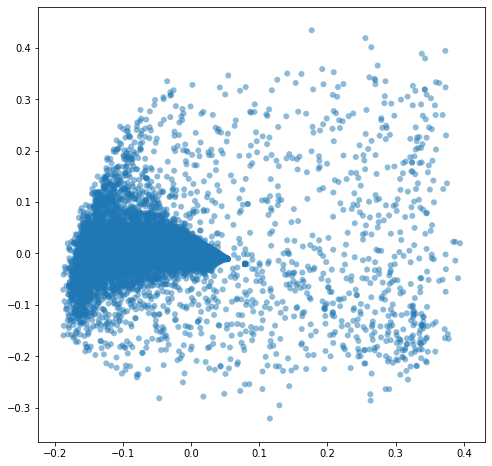



```
# This is formatted as code
```

## Transform to Image

### assigning each feature to a pixel coordinate

In [0]:
# recieve the pca results and return 2 tuples of (max_[axis], mix[axis])
def min_max_pt(pca_res):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    for arr in pca_res:
        cur_x = arr[0]
        cur_y = arr[1]

        if cur_x < min_x:
            min_x = cur_x
        elif cur_x > max_x:
            max_x = cur_x

        if cur_y < min_y:
            min_y = cur_y
        elif cur_y > max_y:
            max_y = cur_y

    return (max_x, min_x), (max_y, min_y)

# x_tup, y_tup = min_max_pt(sample)
# print(x_tup, y_tup, dist_tup)

# receieve pca plot and resolution.
# return a list that each element is a list related to a featur and containing [x_pixel_coordinate, y_pixel_coordinate] related to that featur in the image map
def divide_to_pixels(scatter, resolution):
    res = [] # a list of tuples

    x_range, y_range = min_max_pt(scatter)

    x_dist = x_range[0]-x_range[1]
    y_dist = y_range[0]-y_range[1]

    x_skip_step = x_dist/resolution
    y_skip_step = y_dist/resolution

    x_pixels = [x_range[1]+i*x_skip_step for i in range(1, resolution+1)]
    y_pixels = [y_range[1]+i*y_skip_step for i in range(1, resolution+1)]

    for arr in scatter:
        cur_x = arr[0]
        cur_y = arr[1]

        point_indices = [None]*2
        for i in range(len(x_pixels)-1, -1, -1):
            if cur_x <= x_pixels[i]:
                point_indices[0] = i
            if cur_y <= y_pixels[i]:
                point_indices[1] = i

        res.append(point_indices)

    return res

# for every feature what is the pixel coordinates such as [1,8] means that that featur is related to that pixel
# feature_pix_coordinate = divide_to_pixels(sample, resolution= resolution)
# print(feature_pix_coordinate)
# print(len(feature_pix_coordinate))

### assigning each pixel with a list of corresponding features

In [0]:
# func that will assign list of features number to every pixel
# returns a 2-d array-like that represents every pixel in the image. each value is a list containing number of feature(s) in that pixel (number is by index i.e: using iloc). 
def to_pixel_map(feat_in_pixels, resolution=10):
    pixel_map = [[[] for __ in range(resolution)] for _ in range(resolution)]
    bad_pixels_count = 0
    for num, feat in enumerate(feat_in_pixels):
        if feat[0]==None or feat[1]==None:
            bad_pixels_count += 1
            continue
        pixel_map[feat[1]][feat[0]].append(num)

    return pixel_map

# count how many features are in each pixel
# returns a heat map of counts how many features are in every pixel
def feat_count_per_pixel(resolution, feat_in_pixels):
    heat_map = np.zeros((resolution, resolution))
    bad_pixels_count = 0
    for feat in feat_in_pixels:
        if feat[0]==None or feat[1]==None:
            bad_pixels_count += 1
            continue
        heat_map[feat[1], feat[0]] += 1
    
    return heat_map



# plotting the feature count as a heatmap
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def plot_heat_map(count_of_feat_in_pixel, fig_size):
    df_cm = pd.DataFrame(count_of_feat_in_pixel)
    plt.figure(figsize = (fig_size,fig_size))
    sn.heatmap(df_cm, annot=True)

In [0]:
def df_to_array_of_images(df,pixel_map): 
  print (df.get_value(0, 0, takeable = True))
  print(df.iloc[0:1,0][0]) 
  dataset_as_images=[]
  for index, row in df.iterrows():
    sample_as_image = np.zeros((10,10))
    for i in range(resolution):
      for j in range(resolution):
        listOfGenes = pixel_map[i][j]
        if len(listOfGenes)==0:
          sample_as_image[i][j]=1
        else:
         summary = 0
         for gene in listOfGenes:
          summary = summary + df.get_value(index, gene, takeable = True) 
          # summary = summary + df.iloc[index:index+1,gene][0]
         sample_as_image[i][j]= summary/len(listOfGenes)
    dataset_as_images.append(sample_as_image)
  return dataset_as_images 
X_train_as_image = df_to_array_of_images(X_train,pixel_map)  

0.0
0.0


In [0]:
X_validation_as_image = df_to_array_of_images(X_validation,pixel_map)  

0.0
0.0


## CNN construction

CNN model

In [0]:
from __future__ import print_function

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns
import itertools
from keras.regularizers import l2
from keras.models import Model, Sequential
from keras.datasets import cifar100

from keras.layers import Dense, Conv2D, Flatten, Input, AvgPool2D,MaxPool2D,Dropout,BatchNormalization ,ZeroPadding2D,Activation,MaxPooling2D,LeakyReLU,GlobalMaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import SGD
def create_model(height,width,num_of_classes):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(height, width,1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(num_of_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
  print (model.summary())
  return model


def train (current_model,current_X_train,current_y_train,current_X_validation,current_y_validation):
 history = current_model.fit(np.reshape(current_X_train,(current_X_train.shape[0],current_X_train.shape[1],current_X_train.shape[2],1)),to_categorical(current_y_train),validation_data=(current_X_validation,to_categorical(current_y_validation)),shuffle=True,epochs=150, batch_size = 32)
 return history


def predict (current_model,current_X_test,current_y_test):
 current_model.predict(current_X_test)




In [0]:
model2 = create_model(10,10,5)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 10, 10, 32)        320       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 10, 10, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 10, 10, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 5, 5, 64)          18496     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 5, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 2, 2, 64)        

In [0]:
X_train_as_image = np.asarray(X_train_as_image)
X_train_as_image.shape

X_validation_as_image = np.asanyarray(X_validation_as_image)
t = np.expand_dims(X_train_as_image, axis=3)
y= np.expand_dims(X_validation_as_image, axis=3)

In [0]:
t.shape

(478, 10, 10, 1)

In [0]:
history = train(model2,t,y_train,y,y_validation)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 478 samples, validate on 160 samples
Epoch 1/150
478/478 [==============================] - 8s 16ms/step - loss: 1.4647 - acc: 0.4603 - val_loss: 1.0289 - val_acc: 0.5563
Epoch 2/150
478/478 [==============================] - 0s 336us/step - loss: 1.0627 - acc: 0.5607 - val_loss: 1.0843 - val_acc: 0.4813
Epoch 3/150
478/478 [==============================] - 0s 318us/step - loss: 0.8380 - acc: 0.6590 - val_loss: 1.0270 - val_acc: 0.5062
Epoch 4/150
478/478 [==============================] - 0s 324us/step - loss: 0.7267 - acc: 0.7113 - val_loss: 0.5668 - val_acc: 0.8187
Epoch 5/150
478/478 [==============================] - 0s 287us/step - loss: 0.4695 - acc: 0.8243 - val_loss: 0.4842 - val_acc: 0.8125
Epoch 6/150
478/478 [==============================] - 0s 317us/step - loss: 0.3851 - acc: 0.8619 - val_loss: 0.2812 - val_acc: 0.8875
Epoch 7/150
478/478 [============================

## Main

### running tests

In [0]:
# configuration. TO-DO: read configuration from an outer file
config_working_dataset = 'gene_expression_cancer_data'
config_working_labels = None
config_kpca_kernerl = 'cosine'
config_resolution = 10

# reading the data
dataset, labels = get_dataset(config_working_dataset)
print(f'Dataset `{config_working_dataset}` shape is: {dataset.shape}')
if config_working_labels != None:
    print(f'Dataset labels `{config_working_labels}` shape is: {labels.shape}')


# cleaning data and splitting to [train, validation, test]
splits = split_data(dataset, df_label=labels, data_name=working_dataset)

# unpacking train
train_x = splits['train']
print(f'Original dataset view: ')
display(train_x['original'].head(2))

print (f'\nTranspose dataset view: ')
display(train_x['transpose'].head(2))

# # applying and plotting k-pca
# kpca_point = KPCA(kernel=config_kpca_kernerl, features_df=train_x['transpose'])
# plot_kpca(kpca_point)

# # constructing the image
# features_to_pixels = divide_to_pixels(scatter=kpca_point, resolution=config_resolution)
# pixels_to_features = to_pixel_map(features_to_pixels)
# pixels_features_heat_map = feat_count_per_pixel(resolution=config_resolution, feat_in_pixels=features_to_pixels)
# plot_heat_map(pixels_features_heat_map, fig_size=config_resolution)

# cont'


FileNotFoundError: ignored

Experiment results for kernel: linear


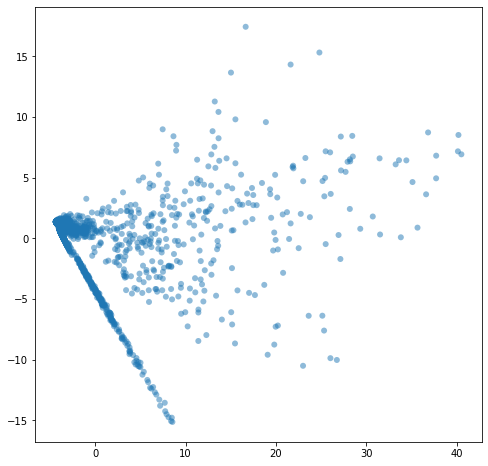


Experiment results for kernel: poly


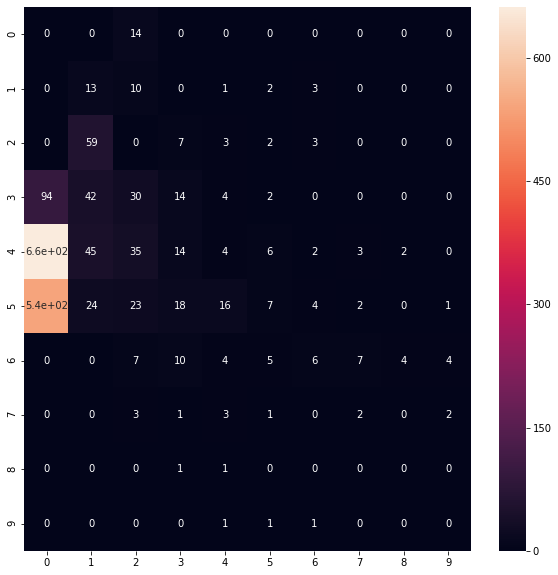

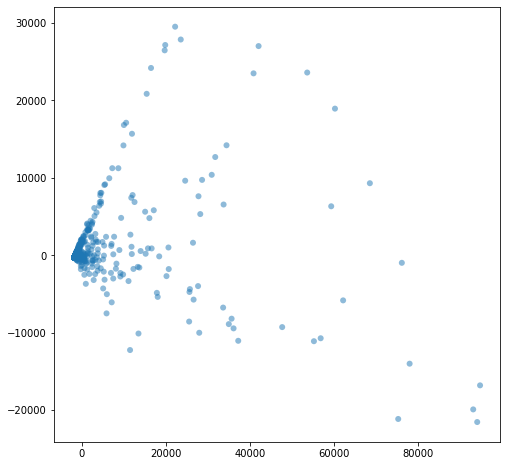


Experiment results for kernel: rbf


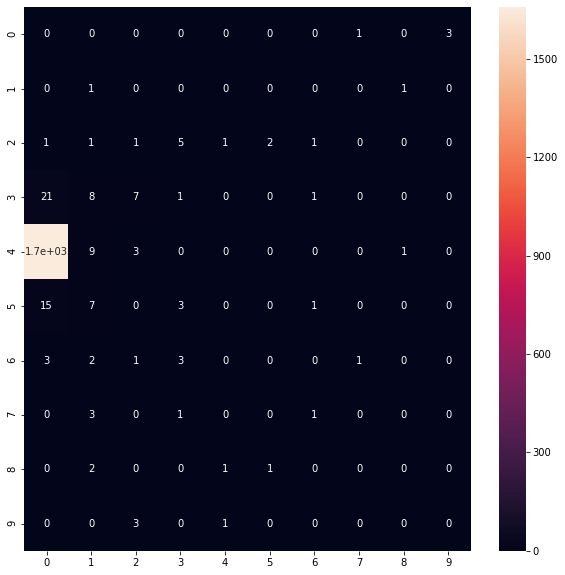

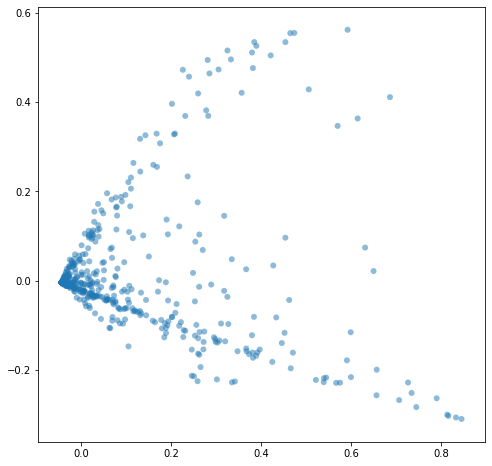


Experiment results for kernel: sigmoid


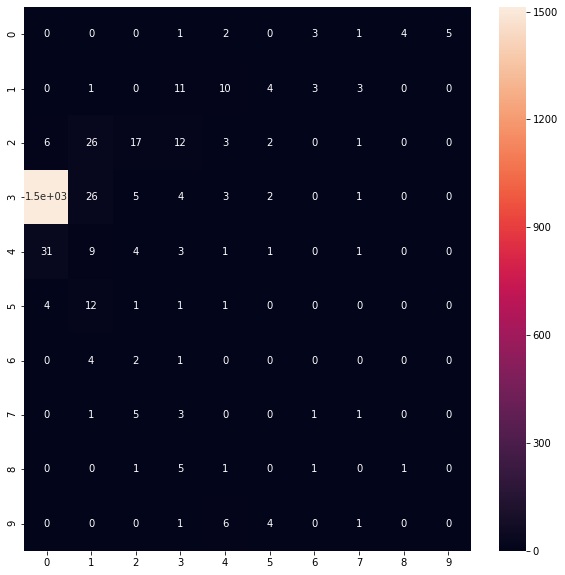

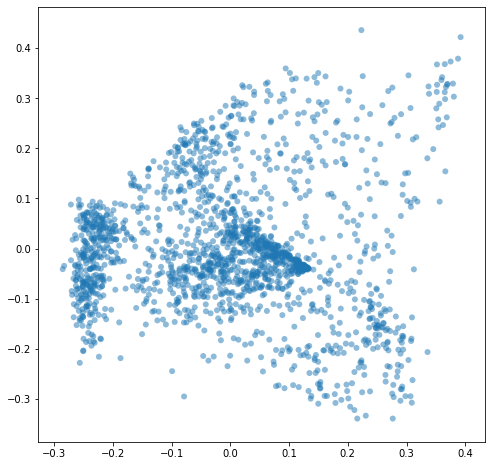


Experiment results for kernel: cosine


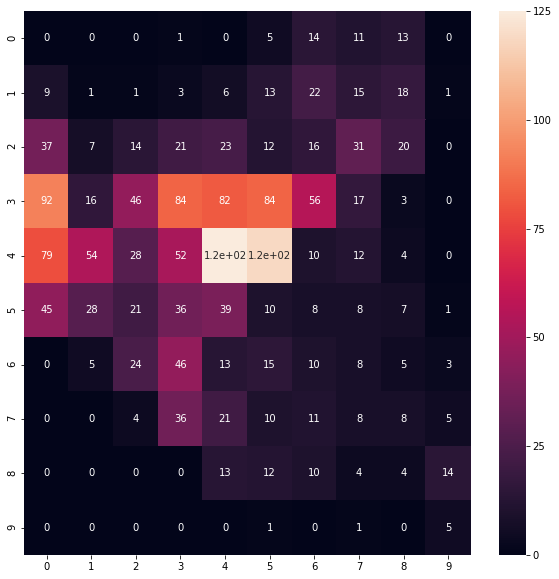

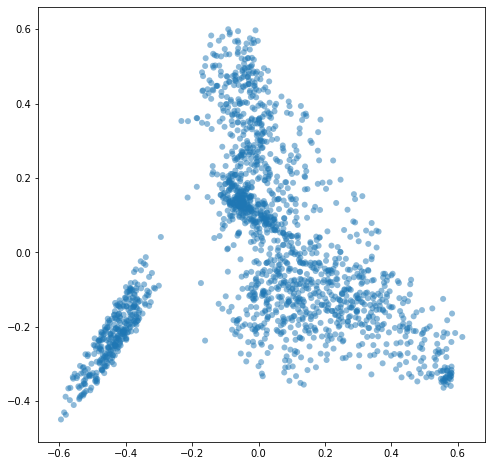

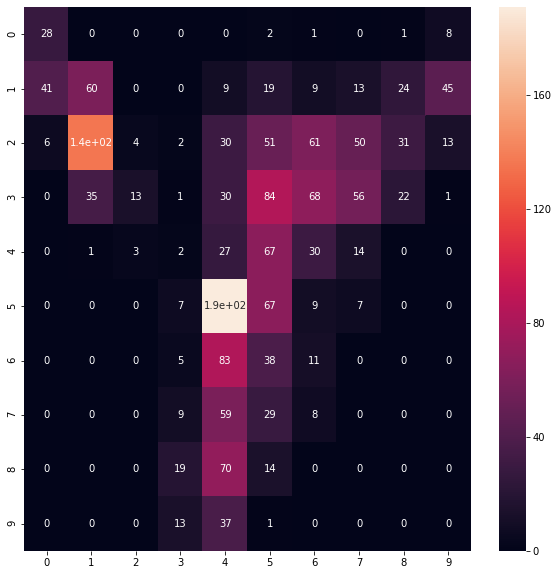

In [0]:
def experiment_types_of_kernels(df):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']

    for kernel in kernels:
        print(f'Experiment results for kernel: {kernel}')
        # applying and plotting k-pca
        kpca_point = KPCA(kernel=kernel, features_df=df)
        plot_kpca(kpca_point)

        # constructing the image
        features_to_pixels = divide_to_pixels(scatter=kpca_point, resolution=config_resolution)
        pixels_to_features = to_pixel_map(features_to_pixels)
        pixels_features_heat_map = feat_count_per_pixel(resolution=config_resolution, feat_in_pixels=features_to_pixels)
        plot_heat_map(pixels_features_heat_map, fig_size=config_resolution)

        print()

experiment_types_of_kernels(train_x['transpose'])